Training with custom Adam optimizer with Morse theory and Floer Homotopy:
Epoch 0, Loss: 5.5411
Epoch 100, Loss: 1.8262
Epoch 200, Loss: 0.5947
Epoch 300, Loss: 0.2810
Epoch 400, Loss: 0.2273
Epoch 500, Loss: 0.2214
Epoch 600, Loss: 0.2209
Epoch 700, Loss: 0.2209
Epoch 800, Loss: 0.2209
Epoch 900, Loss: 0.2209
Training with built-in Adam optimizer:
Epoch 0, Loss: 7.5013
Epoch 100, Loss: 2.6024
Epoch 200, Loss: 0.7763
Epoch 300, Loss: 0.3085
Epoch 400, Loss: 0.2300
Epoch 500, Loss: 0.2215
Epoch 600, Loss: 0.2209
Epoch 700, Loss: 0.2209
Epoch 800, Loss: 0.2209
Epoch 900, Loss: 0.2209
Training with built-in AdamW optimizer:
Epoch 0, Loss: 10.6372
Epoch 100, Loss: 4.5297
Epoch 200, Loss: 1.7258
Epoch 300, Loss: 0.6662
Epoch 400, Loss: 0.3343
Epoch 500, Loss: 0.2474
Epoch 600, Loss: 0.2276
Epoch 700, Loss: 0.2232
Epoch 800, Loss: 0.2220
Epoch 900, Loss: 0.2217
Training with Lion optimizer:
Epoch 0, Loss: 9.6738
Epoch 100, Loss: 9.6738
Epoch 200, Loss: 9.6738
Epoch 300, Loss: 9.6738
Epoch 40

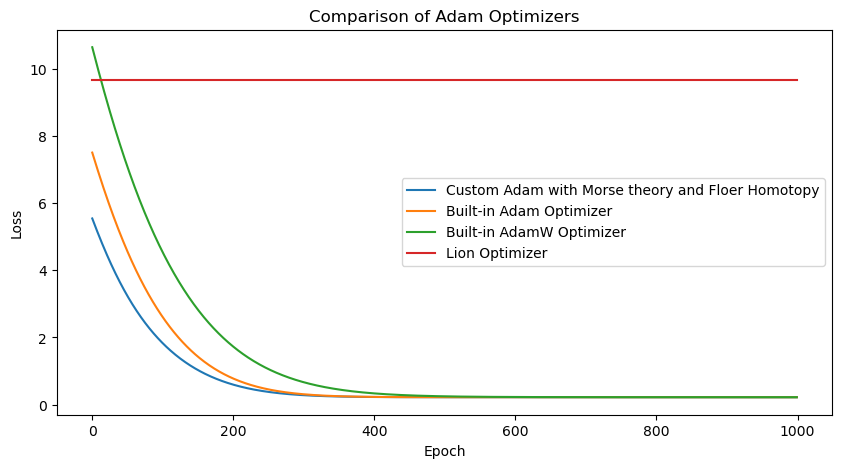

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from lion_pytorch import Lion


np.random.seed(42)
torch.manual_seed(42)

# Generate synthetic data
x = np.random.randn(100)
y = 2 * x + 3 + np.random.randn(100) * 0.5  # true slope is 2, intercept is 3
x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

    
class AdamOptimizerWithMorse(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")

        defaults = dict(lr=lr, betas=betas, eps=eps)
        super(AdamOptimizerWithMorse, self).__init__(params, defaults)

    def floer_homotopy_perturbation(self, params, iteration, enabled=True):
        if not enabled:
            return 0
        perturbation_strength = 0.0001 / (1 + iteration * 1e-3)
        perturbation = torch.sin(params) * perturbation_strength
        return perturbation

    def conditional_curvature(self, exp_avg_sq, classify):
        if classify:
            return exp_avg_sq.sqrt().mean()
        return None

    def classify_critical_point(self, grad, curvature):
        norm_grad = torch.norm(grad)
        if norm_grad < 1e-4 and curvature is not None:
            if curvature > 0:
                return 'min'
            elif curvature < 0:
                return 'max'
            else:
                return 'saddle'
        return None

    def adjust_step_size(self, step_size, type, curvature):
        if type == 'saddle':
            return step_size * 2  # more aggressive step
        elif type == 'min':
            return step_size * (0.5 if curvature > 0.01 else 0.75)  # less aggressive if near flat minima
        return step_size

    def step(self, closure=None):
        """Performs a single optimization step (parameter update)."""
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Update estimates
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                step_size = group['lr'] * (np.sqrt(1 - beta2 ** state['step']) / (1 - beta1 ** state['step']))

                # Apply advanced optimizations
                curvature = self.conditional_curvature(exp_avg_sq, state['step'] % 10 == 0)
                critical_point_type = self.classify_critical_point(grad, curvature)
                step_size = self.adjust_step_size(step_size, critical_point_type, curvature)

                if critical_point_type == 'min':
                    perturbation = self.floer_homotopy_perturbation(p.data, state['step'])
                    exp_avg.add_(perturbation)

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


# Training setup
model = LinearRegressionModel()
criterion = nn.MSELoss()

# Using the custom optimizer
optimizer_custom = AdamOptimizerWithMorse(model.parameters(), lr=0.01)
# Using the built-in Adam optimizer
optimizer_adam = optim.Adam(model.parameters(), lr=0.01)
# Using the built-in AdamW optimizer
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.01)

optimizer_lion = Lion(model.parameters(), lr=0.001)


# Training loop
def train_model(optimizer, epochs=1000):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return losses

# Train with custom optimizer
print("Training with custom Adam optimizer with Morse theory and Floer Homotopy:")
losses_custom = train_model(optimizer_custom)

# Reset model and optimizer
model = LinearRegressionModel()
optimizer_adam = optim.Adam(model.parameters(), lr=0.01)

# Train with built-in Adam optimizer
print("Training with built-in Adam optimizer:")
losses_adam = train_model(optimizer_adam)

# Reset model and optimizer
model = LinearRegressionModel()
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.01)

# Train with built-in AdamW optimizer
print("Training with built-in AdamW optimizer:")
losses_adamw = train_model(optimizer_adamw)


# Reset model and optimizer
model = LinearRegressionModel()
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.01)

# Train with Lion optimizer
print("Training with Lion optimizer:")
losses_lion = train_model(optimizer_lion)


# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(losses_custom, label='Custom Adam with Morse theory and Floer Homotopy')
plt.plot(losses_adam, label='Built-in Adam Optimizer')
plt.plot(losses_adamw, label='Built-in AdamW Optimizer')
plt.plot(losses_lion, label='Lion Optimizer')
plt.title("Comparison of Adam Optimizers")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Training with custom Adam optimizer with Morse theory and Floer Homotopy:
Epoch [1/20], Loss: 0.3109
Epoch [2/20], Loss: 0.1429
Epoch [3/20], Loss: 0.1040
Epoch [4/20], Loss: 0.0839
Epoch [5/20], Loss: 0.0727
Epoch [6/20], Loss: 0.0613
Epoch [7/20], Loss: 0.0541
Epoch [8/20], Loss: 0.0475
Epoch [9/20], Loss: 0.0430
Epoch [10/20], Loss: 0.0401
Epoch [11/20], Loss: 0.0346
Epoch [12/20], Loss: 0.0345
Epoch [13/20], Loss: 0.0305
Epoch [14/20], Loss: 0.0268
Epoch [15/20], Loss: 0.0301
Epoch [16/20], Loss: 0.0249
Epoch [17/20], Loss: 0.0227
Epoch [18/20], Loss: 0.0246
Epoch [19/20], Loss: 0.0224
Epoch [20/20], Loss: 0.0212
Training with built-in Adam optimizer:
Epoch [1/20], Loss: 0.3170
Epoch [2/20], Loss: 0.1444
Epoch [3/20], Loss: 0.1043
Epoch [4/20], Loss: 0.0859
Epoch [5/20], Loss: 0.0738
Epoch [6/20], Loss: 0.0622
Epoch [7/20], Loss: 0.0541
Epoch [8/20], Loss: 0.0472
Epoch [9/20], Loss: 0.0444
Epoch [10/20], Loss: 0.0419
Epoch [11/20], Loss: 0.0365
Epoch [12/20], Loss: 0.0340
Epoch [13

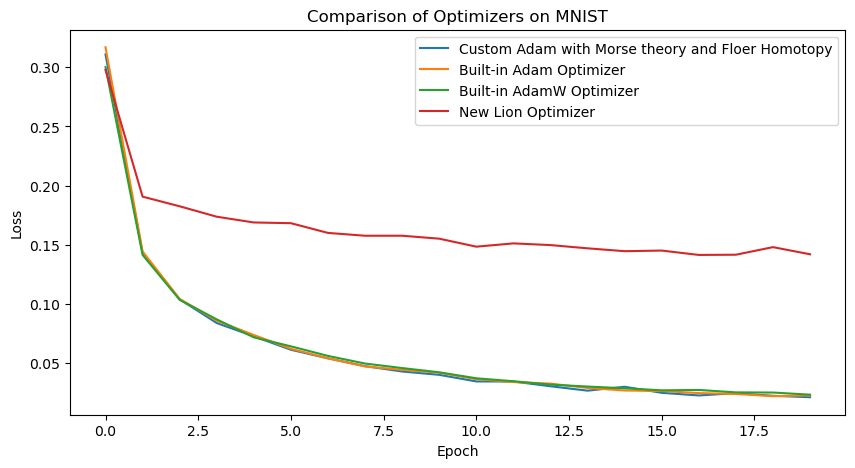

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from lion_pytorch import Lion


torch.cuda.is_available()

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train_model(model, optimizer, criterion, trainloader, epochs=20):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    return losses

# Testing function
def test_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Initialize model, criterion, and optimizers
model_custom = Net()
model_adam = Net()
model_adamw = Net()
model_lion = Net()

criterion = nn.CrossEntropyLoss()

optimizer_custom = AdamOptimizerWithMorse(model_custom.parameters(), lr=0.001)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
optimizer_adamw = optim.AdamW(model_adamw.parameters(), lr=0.001)
optimizer_lion = Lion(model_lion.parameters(), lr=0.001)


# Train and test models
print("Training with custom Adam optimizer with Morse theory and Floer Homotopy:")
losses_custom = train_model(model_custom, optimizer_custom, criterion, trainloader)

print("Training with built-in Adam optimizer:")
losses_adam = train_model(model_adam, optimizer_adam, criterion, trainloader)

print("Training with built-in AdamW optimizer:")
losses_adamw = train_model(model_adamw, optimizer_adamw, criterion, trainloader)

print("Training with Lion optimizer:")
losses_lion = train_model(model_lion, optimizer_lion, criterion, trainloader)

# Test accuracy
accuracy_custom = test_model(model_custom, testloader)
accuracy_adam = test_model(model_adam, testloader)
accuracy_adamw = test_model(model_adamw, testloader)
accuracy_lion = test_model(model_lion, testloader)

print(f"Custom Adam with Morse theory and Floer Homotopy: {accuracy_custom:.2f}%")
print(f"Built-in Adam Accuracy: {accuracy_adam:.2f}%")
print(f"Built-in AdamW Accuracy: {accuracy_adamw:.2f}%")
print(f"New Lion Accuracy: {accuracy_lion:.2f}%")


# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(losses_custom, label='Custom Adam with Morse theory and Floer Homotopy')
plt.plot(losses_adam, label='Built-in Adam Optimizer')
plt.plot(losses_adamw, label='Built-in AdamW Optimizer')
plt.plot(losses_lion, label='New Lion Optimizer')
plt.title("Comparison of Optimizers on MNIST")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [38]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Assuming other parts of your imports and code remain the same

# Load MNIST and modify transform for ViT compatibility
transform = transforms.Compose([
    transforms.Resize(32),  # Resize to the input size expected by ViT
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset as before
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# Replace Net with a ViT model
model_vit = timm.create_model('vit_small_patch16_36x1_224', num_classes=10, pretrained=False)
optimizer_vit = optim.Adam(model_vit.parameters(), lr=0.001)

# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32, 512)  # Adjust the input size to 32x32
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 32*32)  # Adjust flattening to 32x32
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Training and testing functions adapted for use with both FC and ViT models
def train_model(model, optimizer, criterion, trainloader, epochs=20, is_vit=False):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            if is_vit:
                outputs = model(inputs)  # ViT uses the whole image
            else:
                inputs = inputs.view(-1, 32*32)  # Correct the flattening to match 32x32 images
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    return losses

def test_model(model, testloader, is_vit=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            if is_vit:
                outputs = model(inputs)  # ViT uses the whole image
            else:
                inputs = inputs.view(-1, 32*32)  # Correct the flattening to match 32x32 images
                outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Initialize models, criterion, and optimizers
models = [Net() for _ in range(4)]
optimizers = [
    AdamOptimizerWithMorse(models[0].parameters(), lr=0.001),
    optim.Adam(models[1].parameters(), lr=0.001),
    optim.AdamW(models[2].parameters(), lr=0.001),
    Lion(models[3].parameters(), lr=0.001)
]
names = ["Custom Adam with Morse theory and Floer Homotopy", "Built-in Adam", "Built-in AdamW", "New Lion"]
criterion = nn.CrossEntropyLoss()

# Train and test all models
for model, optimizer, name in zip(models, optimizers, names):
    print(f"Training with {name}:")
    losses = train_model(model, optimizer, criterion, trainloader)
    accuracy = test_model(model, testloader)
    print(f"{name} Accuracy: {accuracy:.2f}%")

Training with Custom Adam with Morse theory and Floer Homotopy:
Epoch [1/20], Loss: 0.3090
Epoch [2/20], Loss: 0.1470
Epoch [3/20], Loss: 0.1101
Epoch [4/20], Loss: 0.0925
Epoch [5/20], Loss: 0.0822
Epoch [6/20], Loss: 0.0697
Epoch [7/20], Loss: 0.0674
Epoch [8/20], Loss: 0.0580
Epoch [9/20], Loss: 0.0556
Epoch [10/20], Loss: 0.0510
Epoch [11/20], Loss: 0.0471
Epoch [12/20], Loss: 0.0438
Epoch [13/20], Loss: 0.0422
Epoch [14/20], Loss: 0.0389
Epoch [15/20], Loss: 0.0360
Epoch [16/20], Loss: 0.0360
Epoch [17/20], Loss: 0.0326
Epoch [18/20], Loss: 0.0316
Epoch [19/20], Loss: 0.0310
Epoch [20/20], Loss: 0.0298
Custom Adam with Morse theory and Floer Homotopy Accuracy: 97.88%
Training with Built-in Adam:
Epoch [1/20], Loss: 0.3131
Epoch [2/20], Loss: 0.1485
Epoch [3/20], Loss: 0.1126
Epoch [4/20], Loss: 0.0930
Epoch [5/20], Loss: 0.0811
Epoch [6/20], Loss: 0.0715
Epoch [7/20], Loss: 0.0686
Epoch [8/20], Loss: 0.0580
Epoch [9/20], Loss: 0.0582
Epoch [10/20], Loss: 0.0503
Epoch [11/20], Loss

0.209729 M parameters
Lion step 0: train loss 3.7108
Lion step 100: train loss 2.5031
Lion step 200: train loss 2.3593
Lion step 300: train loss 2.2598
Lion step 400: train loss 2.1777
Lion step 500: train loss 2.1383
Lion step 600: train loss 2.1161
Lion step 700: train loss 2.1273
Lion step 800: train loss 2.1321
Lion step 900: train loss 2.1941
Lion step 999: train loss 2.2210
AdamM step 0: train loss 3.8687
AdamM step 100: train loss 2.5059
AdamM step 200: train loss 2.3605
AdamM step 300: train loss 2.2554
AdamM step 400: train loss 2.1715
AdamM step 500: train loss 2.1030
AdamM step 600: train loss 2.0624
AdamM step 700: train loss 2.0253
AdamM step 800: train loss 1.9947
AdamM step 900: train loss 1.9398
AdamM step 999: train loss 1.9306
AdamW step 0: train loss 4.2032
AdamW step 100: train loss 2.6816
AdamW step 200: train loss 2.5114
AdamW step 300: train loss 2.4261
AdamW step 400: train loss 2.3832
AdamW step 500: train loss 2.3222
AdamW step 600: train loss 2.2508
AdamW ste

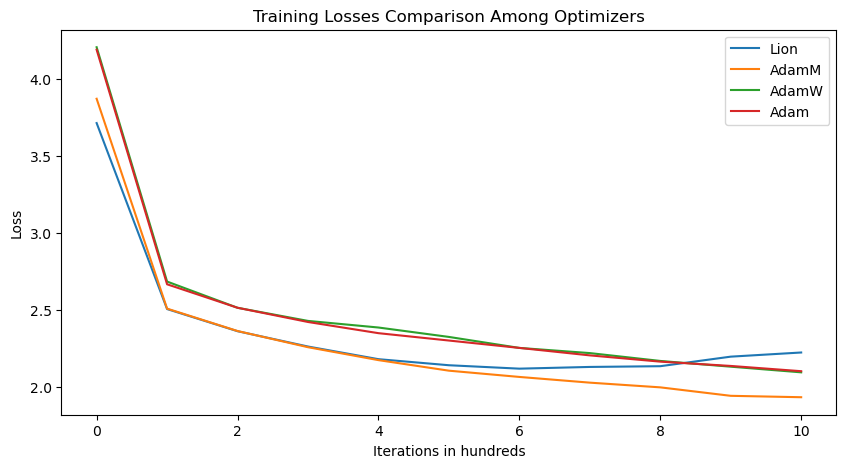



YERDORRRY:
Tcowird, O la, bet
Yaire my bead enavegrtand meall ands:
Waith foulqorth bubar dilth ane awice my.

HDY arom I mughtowns, to fitie bet mil;
I lincaes if enden cin latiHell; ove theat him preart.

Wableselll not, and thull cour by:
Sarriness hiw you lomake norfopetelives
And the the to killo Winst wher eiibll to th dombive ceeshimeds pood

And ster the danteruptef sorr igre!
Buft wity ale of whis dere?

KISTING HKING ER
KENSS&is:
Sads beared and thimin cour ay andy ire tome
fr thou hik ne to to sirgy.
You I this tha sone thense.

And fortwer'd matand thou sucines the wety on,
Thource ffepmy shim cas lom my.
Mome thal in stroe earded heemovet: im parsce of's if mee?
Yorse so not hist magRilt, say, com lovescest?
What sich he neesoxme merech! beakes agle cobun with s slevitls;
Wham, do sowll shim a if macks hins,
An demink, the ving noth Ceatey
fever, oou tius the shis the summe liplytanon what thavist cougles,
Berell maron sour the pait.
Thwat hourd, Wort in for Goy thee in.

In [62]:
######## This is GPT - NANO ###################### Need to be work on........

#adapted from: https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing#scrollTo=hoelkOrFY8bN


import torch
import torch.nn as nn
from torch.nn import functional as F


from lion_pytorch import Lion



# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters =  1000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


# print the number of parameters in the model
BigramLanguageModel()
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Optimizers
optimizer_adam = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_adamw = torch.optim.AdamW(model.parameters(), lr=learning_rate)
optimizer_adamm = AdamOptimizerWithMorse(model.parameters(), lr=learning_rate)  # Make sure this is defined
optimizer_lion = Lion(model.parameters(), lr=learning_rate)  # Make sure this is defined

# Function to run training loop
def create_model():
    model = BigramLanguageModel()
    return model.to(device)

# Function to run training loop
def run_training(optimizer, name, model):
    losses = {'train': []}
    for iter in range(max_iters):
        xb, yb = get_batch('train')
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if iter % eval_interval == 0 or iter == max_iters - 1:
            eval_losses = estimate_loss()
            losses['train'].append(eval_losses['train'].item())
            print(f"{name} step {iter}: train loss {eval_losses['train']:.4f}")

    return losses

# Initialize and run training for each optimizer
losses_dict = {}
for name in ['Lion','AdamM', 'AdamW', 'Adam']:
    model = create_model()  # Create a fresh model instance for each optimizer
    optimizer = {
        'Adam': torch.optim.Adam(model.parameters(), lr=learning_rate),
        'AdamW': torch.optim.AdamW(model.parameters(), lr=learning_rate),
        'AdamM': AdamOptimizerWithMorse(model.parameters(), lr=learning_rate),
        'Lion': Lion(model.parameters(), lr=learning_rate)
    }[name]
    losses_dict[name] = run_training(optimizer, name, model)

# Plotting the results for training losses
plt.figure(figsize=(10, 5))
for name, losses in losses_dict.items():
    plt.plot(losses['train'], label=name)
plt.title('Training Losses Comparison Among Optimizers')
plt.xlabel('Iterations in hundreds')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate text from the last trained model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = model.generate(context, max_new_tokens=2000)
print(decode(generated_text[0].tolist()))
